Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513/EEL410250 - Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\RR}{\mathbb{R}}$


# Exercício 4: Regressão Logística

Neste exercício você irá aplicar um classificador de regressão logística em diversos conjuntos de dados. 
Além disso, você irá explorar a adição de atributos polinomiais e a utilização de regularização, bem como outras formas de avaliação de classificadores binários. Finalmente, você irá investigar técnicas de classificação multi-classe.

In [584]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_data(n_samples=20, n_classes=2, overlap=0, x_scale=[0,1], random_state=None):
    '''Generate 1-D classification dataset'''
    assert overlap <= 1
    rng = np.random.RandomState(random_state)
    X = np.zeros((n_samples,1))
    y = np.zeros(n_samples)
    for i in range(n_samples):
        k = i % n_classes
        X[i,0] = (k*(1-overlap) + rng.rand())/((n_classes-1)*(1-overlap) + 1)
        y[i] = k
    X = x_scale[0] + (x_scale[1]-x_scale[0])*X
    return X, y

def plot_data(X, y, colors=['bo','rx','gs','md','c^','yP']):
    ''' Plot 1-D or 2-D classification dataset '''
    assert len(X.shape) == 2 and len(y.shape) == 1
    classes = np.unique(y)
    assert len(classes) <= len(colors)
    dim = X.shape[1]
    assert 0 < dim <= 2
    if dim == 1:
        for i in range(len(classes)):
            plt.plot(X[y==classes[i],0], np.zeros(np.sum(y==classes[i])), colors[i])
        plt.gca().axes.get_yaxis().set_ticks([])
    else:
        for i in range(len(classes)):
            plt.plot(X[y==classes[i],0], X[y==classes[i],1], colors[i])
    return

def plot_boundary(model, X, colors=['b','r','g','m','c','y'], N=400, gap=1e-9):
    ''' Plot boundary for a 1-D or 2-D classifier '''
    assert len(X.shape) == 2 and len(y.shape) == 1
    dim = X.shape[1]
    assert 0 < dim <= 2
    x1_min, x1_max = X[:,0].min()-gap, X[:,0].max()+gap
    if dim == 1:
        x2_min, x2_max = -1, 1
        N2 = 2
    else:
        x2_min, x2_max = X[:,1].min()-gap, X[:,1].max()+gap
        N2 = N
    xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max,N), np.linspace(x2_min,x2_max,N2))
    if dim == 1:
        X = np.c_[xx1.reshape(-1)]
    else:
        X = np.c_[xx1.reshape(-1), xx2.reshape(-1)]
    y_pred = model.predict(X)
    from sklearn.preprocessing import LabelEncoder
    enc = LabelEncoder()
    y_pred = enc.fit_transform(y_pred)
    assert len(enc.classes_) <= len(colors)
    levels = np.arange(len(enc.classes_)+1)-0.5
    y_pred = y_pred.reshape(xx1.shape)
    plt.contourf(xx1, xx2, y_pred, levels, colors=colors, alpha=0.25)
    plt.contour(xx1, xx2, y_pred, levels, colors='k', linewidths=1)
    return

def plot_errors(model, X, y):
    ''' Draws a square around each incorrect prediction '''
    assert len(X.shape) == 2 and len(y.shape) == 1
    dim = X.shape[1]
    assert 0 < dim <= 2
    err = model.predict(X) != y
    vert = np.zeros(np.sum(err))
    if dim == 2:
        vert = X[err,1]
    plt.plot(X[err,0], vert, 'ks', mfc='none', markersize=10)
    return

In [585]:
# More imports

# 1. Conjunto de dados #1

O primeiro conjunto de dados que usaremos pode ser gerado e visualizado pelos comandos abaixo.

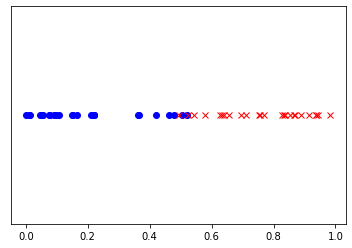

In [586]:
X,y = gen_data(n_samples=50, n_classes=2, overlap=0.1, random_state=1)
plot_data(X, y)

## Classificação linear

1. Treine um classificador de regressão logística sem regularização e trace um gráfico mostrando o conjunto de treinamento e as regiões de decisão do classificador. 
1. Reporte a acurácia (= # de acertos / tamanho do conjunto) do classificador.
1. Determine o valor do limiar de decisão a partir dos parâmetros do modelo.

#### Dicas

- Funções úteis:

```python
sklearn.linear_model.LogisticRegression() # utilize penalty='none'
plot_data(), plot_boundary() # fornecidas, utilize os parâmetros default
LogisticRegression.score(), .coef_, .intercept_
```

-  Caso sua versão do sklearn seja inferior a 0.22, utilize a opção `solver='lbfgs'` (padrão a partir de 0.22) no `LogisticRegression()`

In [587]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
sklearn.__version__

'0.22.1'

In [588]:
model = LogisticRegression(penalty='none')
model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [589]:
pred = model.predict(X)
pred

array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.])

Training accuracy: 0.96%
Decision threshold:0.5108316037797369


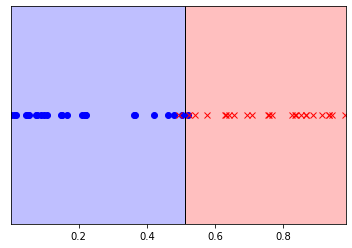

In [591]:
print(f"Training accuracy: {model.score(X,y)}%")
print(f"Decision threshold:{np.abs(float(model.intercept_ / model.coef_))}")
plot_data(X,y)
plot_boundary(model,X)

4. Trace o gráfico da predição do modelo de regressão (i.e., da variável contínua $\tilde{y} = \sigma(\bw^T\bx$)) sobre o conjunto de treinamento. Faça isso de três formas diferentes e confirme que todas fornecem o mesmo resultado:
 1. Usando a função `.predict_proba()` do modelo
 1. Escrevendo sua própria implementação a partir da função `.decision_function()`, a qual retorna o score de confiança $z = \bw^T\bx$
 1. Escrevendo sua própria implementação a partir dos parâmetros `.coef_` e `.intercept_`

Resposta do professor:
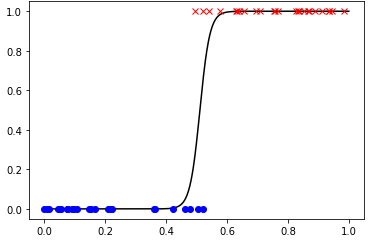

#### 4.A. Usando a função `.predict_proba()` do modelo

In [1]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [630]:
yhat = np.log(model.predict_proba(X)[:,1] / model.predict_proba(X)[:,0])
sig = sigmoid(yhat)

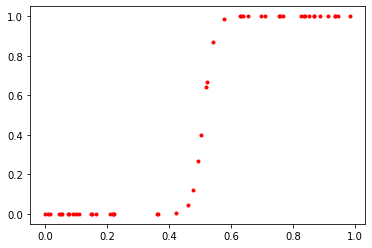

In [633]:
#O uso [:,1] no código lhe dará as probabilidades de obter a saída como 1. 
#Se você substituir 1 por 0 no código acima, você só terá as probabilidades de obter a saída como 0.
plt.plot(X,sig,'r.')
#plt.plot(X,sig[:,1],'b.')

#### 4.B.Usando a função decision_function

In [634]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [653]:
z = (model.decision_function(X))
sig = sigmoid(z)

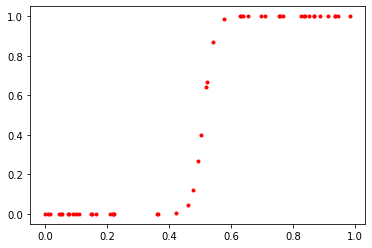

In [655]:
plt.plot(X,sig,'r.')

#### 4.C. Escrevendo sua própria implementação a partir dos parâmetros `.coef_` e `.intercept_`

In [685]:
w = np.ones(2)
w[0] = model.intercept_
w[1] = model.coef_[0][0]
w = np.c_[w]
w

array([[-31.2763806 ],
       [ 61.22640097]])

In [693]:
yhat = X * w[1] + w[0]

In [694]:
sig = sigmoid(yhat)

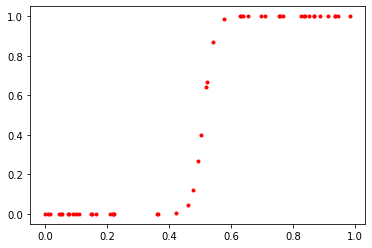

In [695]:
plt.plot(X,sig,'r.')

5. Varie o grau de sobreposição no gerador do conjunto de dados (parâmetro `overlap`) e repita o gráfico da predição do item anterior. Para facilitar, copie e cole todos os comandos e os organize em um `for` (ou, se preferir, utilize `ipywidgets.interact`). Utilize o mesmo `seed` do gerador de números aleatórios em todos os casos (parâmetro `random_state` da função `gen_data()`), para eliminar a variabilidade e assim enfatizar a influência do grau de sobreposição.
1. Comente sobre os resultados observados.

In [ ]:
X,y = gen_data(n_samples=50, n_classes=2, overlap=0.1, random_state=1)
plot_data(X, y)

In [722]:
from ipywidgets import interact

@interact(overlap = (0.01, 1,0.01) , random_state = (1,50,1))
def gen(overlap,random_state):
    X,y = gen_data(n_samples=50, n_classes=2, overlap=overlap, random_state=random_state)
    plot_data(X, y)
    plot_boundary(model,X)
    
    plt.show()
    w = np.ones(2)
    w[0] = model.intercept_
    w[1] = model.coef_[0][0]
    w = np.c_[w]

    yhat = X * w[1] + w[0]

    sig = sigmoid(yhat)

    plt.plot(X,sig,'r.')
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='overlap', max=1.0, min=0.01, step=0.01), IntSlider(v…

Ao aumentar o valor de overlap, alguns dados estão sendo classificados de maneira incorreta.

# 2. Conjunto de dados #2

O segundo conjunto de dados pode ser gerado pelos comandos abaixo.

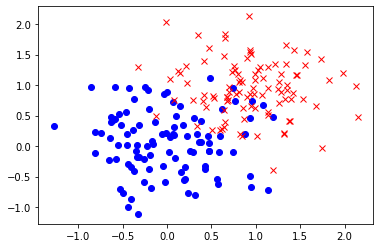

In [723]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, n_features=2, centers=[[0,0],[1,1]], cluster_std=0.5, random_state=0)
plot_data(X, y)

## Classificação linear

1. Treine um classificador de regressão logística sem regularização e trace um gráfico mostrando o conjunto de treinamento e as regiões de decisão do classificador.
1. Reporte o número de iterações realizadas pelo otimizador, a acurácia do classificador e o vetor de parâmetros $\bw$ (incluindo o termo de *bias* $w_0 = b$).
1. Adicione regularização $\ell_2$ e vá aumentando gradativamente o grau de regularização ($\lambda$) e observando seu impacto no vetor $\bw$. Note que o sklearn utiliza como parâmetro de regularização exatamente o inverso, $C = 1/\lambda$.
1. Adicionar regularização se mostrou útil? Por quê?

In [725]:
model = LogisticRegression(penalty='none')
model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [726]:
print(X.shape)
y.shape

(200, 2)


(200,)

In [727]:
w = np.ones(3)
w[0] = model.intercept_
w[1] = model.coef_[0][0]
w[2] = model.coef_[0][1]

Number of iterations: 11
Train accuracy: 91.0%
w = [-3.67594993  3.66197729  3.74117257]


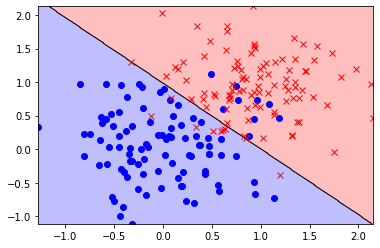

In [728]:
print(f"Number of iterations: {int(model.n_iter_)}")
print(f"Train accuracy: {model.score(X,y)*100}%")
print(f"w = {w}")
plot_boundary(model,X)
plot_data(X,y)

**2.3.Adicione regularização  ℓ2  e vá aumentando gradativamente o grau de regularização ( 𝜆 ) e observando seu impacto no vetor  𝐰 . Note que o sklearn utiliza como parâmetro de regularização exatamente o inverso,  𝐶=1/𝜆 .**

In [737]:
from ipywidgets import interact

@interact(lamb = (10e-9,5, 10e-9))
def train(lamb):
    model = LogisticRegression(penalty='l2', C= 1/lamb)
    model.fit(X,y)
    plot_data(X,y)
    
    w = np.ones(3)
    w[0] = model.intercept_
    w[1] = model.coef_[0][0]
    w[2] = model.coef_[0][1]
    
    #print(model)
    plot_boundary(model, X) 
    print(model)
    print(f"Number of iterations: {int(model.n_iter_)}")
    print(f"Train accuracy: {model.score(X,y)*100}%")
    print(f"w = {w}")

interactive(children=(FloatSlider(value=2.5, description='lamb', max=5.0, min=1e-08, step=1e-08), Output()), _…

**Adicionar regularização se mostrou útil? Por quê.**
Não. Apenas reduz as iterações e o valor no vetor w.

## Implementação em Python

Escreva uma implementação própria do classificador, completando a classe abaixo. Esta implementação é parcialmente compatível com o sklearn; em particular, as classes herdadas permitem automaticamente a utilização da função `.score()`. Para realizar o treinamento utilizaremos o otimizador do SciPy com o método BFGS (padrão do SciPy para problemas sem restrições), um método [quase-Newton](https://en.wikipedia.org/wiki/Quasi-Newton_method) que requer apenas o cálculo do gradiente.

5. Complete as funções `decision_function`, `predict_proba` (que você já implementou acima) e `predict`.
1. Complete a função objetivo da otimização `_fobj`. Esta função deve retornar o valor da função custo e do gradiente no ponto atual ($\bw$).
1. Repita os itens da seção anterior com o seu classificador e compare com a versão do sklearn. Confirme que o valor da acurácia é idêntico e os valores de $\bw$ são muito próximos (até pelo menos o terceiro dígito significativo).

Após essa parte, você pode ignorar a sua implementação e passar a usar a implementação do sklearn.

#### Dicas
- Ao invés de implementar a função logística, utilize a implementação do SciPy (possivelmente renomeando para um nome mais conveniente):
```python
from scipy.special import expit as sigmoid
```
- Adicione um valor pequeno e positivo (ex: `eps = 1e-200`) dentro do argumento do `np.log()` para evitar erros quando o argumento é igual a zero.

In [738]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit as sigmoid

class Model(BaseEstimator, ClassifierMixin):
    ''' Logistic regression with L2 regularization '''
    def __init__(self, lamb=0):
        self.lamb = lamb
        return
    
    def _add_ones(self, X):
        # Add column of ones
        X_new = np.c_[np.ones(X.shape[0]), X]
        return X_new
    
    def _fobj(self, w, X, y):
        # Compute cost and gradient for optimization
        eps = 1e-200
        m = len(y)
        yhat = sigmoid(X @ w)
        J = (-y.T @ np.log(yhat + eps) - (1 - y).T @ np.log(1 - yhat + eps)) / m
        grad = (X.T @ (yhat - y))/m
        return J, grad
    
    def fit(self, X, y):
        # Fit using BFGS solver (SciPy's default)
        from scipy.optimize import minimize
        X = self._add_ones(X)
        res = minimize(fun=self._fobj, x0=np.zeros(X.shape[1]), jac=True, args=(X,y))
        self.w = res.x
        self.n_iter_ = np.array([res.nit])
        self.J = self._fobj(self.w, X, y)[0]
        return self
    
    def decision_function(self, X):
        X = self._add_ones(X)
        z = X @ self.w
        return z
    
    def predict_proba(self, X):
        y_tilde = model.predict_proba(X)
        return y_tilde

    def predict(self, X):
        y_pred = (self.decision_function(X) > 0).astype(int)
        return y_pred

In [739]:
model = Model()

In [740]:
model.fit(X,y)

Model(lamb=0)

In [741]:
y_pred = model.predict(X)

In [742]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1])

In [743]:
y

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1])

Repetindo com os itens da sessão anterior

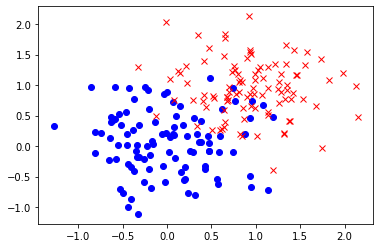

In [744]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, n_features=2, centers=[[0,0],[1,1]], cluster_std=0.5, random_state=0)
plot_data(X, y)

In [745]:
model = Model()
model.fit(X,y)

Model(lamb=0)

In [746]:
model.w

array([-3.6760325 ,  3.66198156,  3.74127557])

Train accuracy: 91.0%
w = [-3.6760325   3.66198156  3.74127557]


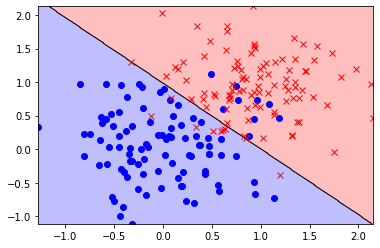

In [747]:
print(f"Train accuracy: {model.score(X,y)*100}%")
print(f"w = {model.w}")
plot_boundary(model,X)
plot_data(X,y)

Resposta do professor:
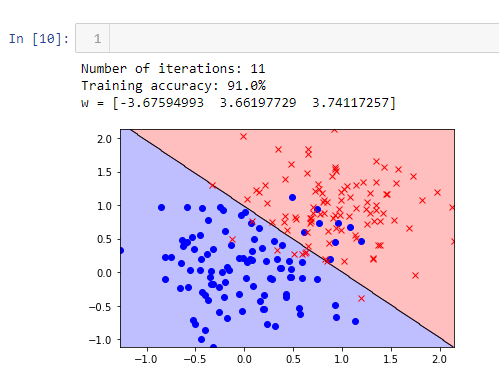

# 3. Conjunto de dados #3

O próximo conjunto de dados é gerado pelos comandos abaixo. Note que agora temos também conjuntos de validação e de teste (extremamente grandes para fins didáticos).

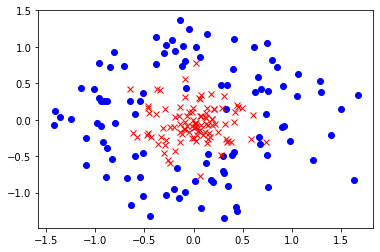

In [748]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=200, noise=0.28, factor=0, random_state=4)
X_val, y_val = make_circles(n_samples=10000, noise=0.28, factor=0, random_state=5)
X_test, y_test = make_circles(n_samples=10000, noise=0.28, factor=0, random_state=6)
plot_data(X,y)

## Adicionando atributos

1. Inicialmente, treine o classificador sem regularização, trace o gráfico das regiões de decisão e reporte o número de iterações, bem como a acurácia nos conjuntos de treinamento e de validação.
1. Aprimore o modelo adicionando atributos polinomiais, até obter 100% de acurácia no conjunto de treinamento.
1. Comente sobre o que você observou, tanto do ponto de vista quantitativo (acurácia) quanto qualitativo (formato regiões de decisão).
1. Em seguida, para o grau encontrado acima, introduza regularização $\ell_2$ e vá aumentando gradualmente (desde $\lambda = 10^{-9}$ ou menor) e verifique o comportamento do modelo. Novamente, comente sobre o que você observou.
1. Qual lhe parece a escolha mais interessante de modelo? Por quê?
1. Para o modelo escolhido, meça a acurácia no conjunto de teste e compare-a com a de validação.

#### Dicas
- Lembre que não há necessidade de incluir o termo constante (*bias*) nos atributos polinomiais adicionados.
- Caso tenha dificuldades de convergência, você pode experimentar, por exemplo:
 - aumentar o número máximo de iterações do otimizador (parâmetro `max_iter`);
 - utilizar um escalonador de atributos. Experimente aplicá-lo em diferentes posições no *pipeline* até obter os melhores resultados. (No meu caso a melhor escolha foi no início.)
- Para acessar o último modelo (o estimador) dentro de um *pipeline*, utilize `model.steps[-1][1]`

Inicialmente, treine o classificador sem regularização, trace o gráfico das regiões de decisão e reporte o número de iterações, bem como a acurácia nos conjuntos de treinamento e de validação.

In [749]:
model = LogisticRegression(penalty = 'none')
model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Number of iterations: 5
Train accuracy: 58.5%


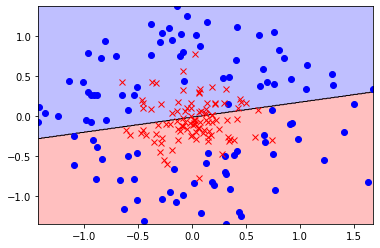

In [750]:
print(f"Number of iterations: {int(model.n_iter_)}")
print(f"Train accuracy: {model.score(X,y)*100}%")
plot_data(X,y)
plot_boundary(model,X)

Number of iterations: 5
Train accuracy: 49.0%


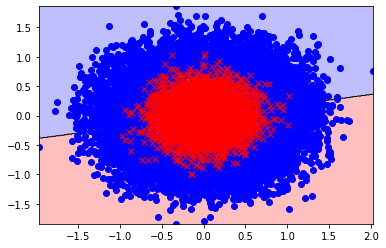

In [751]:
print(f"Number of iterations: {int(model.n_iter_)}")
print(f"Train accuracy: {model.score(X_val,y_val)*100}%")
plot_data(X_val,y_val)
plot_boundary(model,X_val)

Aprimore o modelo adicionando atributos polinomiais, até obter 100% de acurácia no conjunto de treinamento.

In [752]:
from ipywidgets import interact
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

@interact(degree = (0,37,1), maxiter = (100,2000,1))
def train(degree, maxiter):
    poly = PolynomialFeatures(degree = degree)
    model = make_pipeline(poly, LogisticRegression(penalty = 'none', max_iter = maxiter))
    model.fit(X,y)    
    #print(model)
    print(f"Train accuracy: {model.score(X,y)*100}%")
    plot_data(X,y)
    plot_boundary(model, X) 
#degree = 14
#iter = 928

interactive(children=(IntSlider(value=18, description='degree', max=37), IntSlider(value=1050, description='ma…

**Comente sobre o que você observou, tanto do ponto de vista quantitativo (acurácia) quanto qualitativo (formato regiões de decisão)** A acurácia vai alterando conforme as iterações, muitas vezes de maneira aleatória, não seguindo um valor crescente ou decrescente. Quanto maior a acurácia, a curva vai se ajustando melhor ao modelo.

**Em seguida, para o grau encontrado acima, introduza regularização $\ell_2$ e vá aumentando gradualmente (desde $\lambda = 10^{-9}$ ou menor) e verifique o comportamento do modelo. Novamente, comente sobre o que você observou.**

C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train accuracy: 100.0%


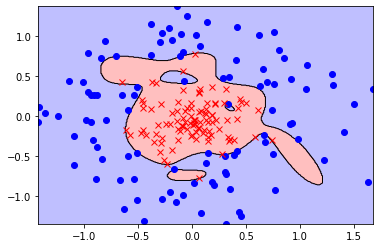

In [753]:
lamb = 10e-9
max_iter = 2173
poly = PolynomialFeatures(degree = 14)
model = make_pipeline(poly, LogisticRegression(penalty = 'l2', C = 1 / lamb, max_iter = max_iter))
model.fit(X,y)    
#print(model)
print(f"Train accuracy: {model.score(X,y)*100}%")
plot_data(X,y)
plot_boundary(model, X) 

C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train accuracy: 100.0%


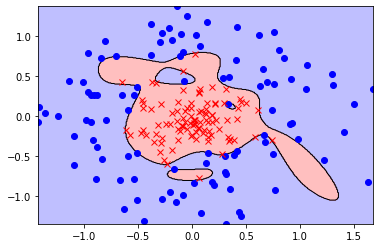

In [754]:
lamb = 10e-10
max_iter = 1250
poly = PolynomialFeatures(degree = 14)
model = make_pipeline(poly, LogisticRegression(penalty = 'l2', C = 1 / lamb, max_iter = max_iter))
model.fit(X,y)    
#print(model)
print(f"Train accuracy: {model.score(X,y)*100}%")
plot_data(X,y)
plot_boundary(model, X) 

C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train accuracy: 100.0%


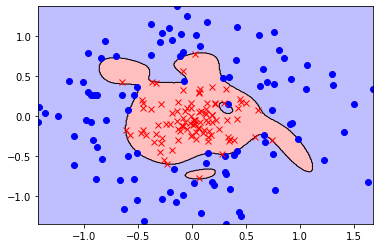

In [755]:
lamb = 10e-15
max_iter = 860
poly = PolynomialFeatures(degree = 14)
model = make_pipeline(poly, LogisticRegression(penalty = 'l2', C = 1 / lamb, max_iter = max_iter))
model.fit(X,y)    
#print(model)
print(f"Train accuracy: {model.score(X,y)*100}%")
plot_data(X,y)
plot_boundary(model, X) 

**Resposta:** Conforme reduz o valor de lambda, aumenta a acurácia e reduz o número de iterações

**Qual lhe parece a escolha mais interessante de modelo? Por quê?** Utilizando a regularização l2. Permite convergir com menos iterações.

**Para o modelo escolhido, meça a acurácia no conjunto de teste e compare-a com a de validação.**

Conjunto de validação:

C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Val accuracy: 90.2%


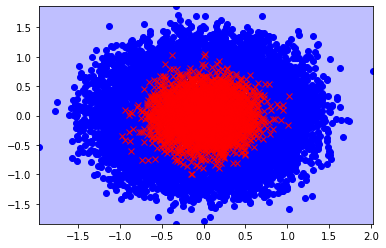

In [756]:
lamb = 10e-10
max_iter = 550
poly = PolynomialFeatures(degree = 14)
model = make_pipeline(poly, LogisticRegression(penalty = 'l2', C = 1 / lamb, max_iter = max_iter))
model.fit(X,y)    
#print(model)
print(f"Val accuracy: {model.score(X_val,y_val)*100}%")
plot_data(X_val,y_val)
plot_boundary(model, X_val) 

Conjunto de teste:

C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test accuracy: 90.42%


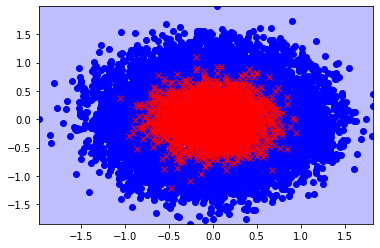

In [757]:
lamb = 10e-10
max_iter = 550
poly = PolynomialFeatures(degree = 14)
model = make_pipeline(poly, LogisticRegression(penalty = 'l2', C = 1 / lamb, max_iter = max_iter))
model.fit(X,y)    
#print(model)
print(f"Test accuracy: {model.score(X_test,y_test)*100}%")
plot_data(X_test,y_test)
plot_boundary(model, X_test) 

**=======================================================================================================================**

# 4. Conjunto de dados #4

O próximo conjunto de dados é gerado pelos comandos abaixo.

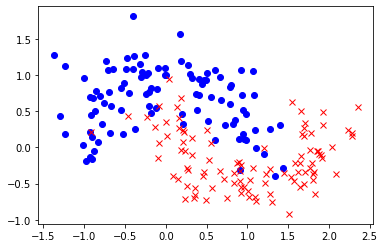

In [758]:
from sklearn.datasets import make_moons

np.random.seed(2019*2)
X, y = make_moons(n_samples=200, noise=0.25)
X_val, y_val = make_moons(n_samples=10000, noise=0.25)
X_test, y_test = make_moons(n_samples=10000, noise=0.25)
plot_data(X, y)

## Desenvolvimento do modelo

1. Desenvolva um bom classificador de regressão logística, da forma que achar mais adequada.
1. Justifique a sua escolha. Em particular, você consegue justificar que o modelo não está sofrendo nem de underfitting nem de overfitting?

In [759]:
from ipywidgets import interact
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

@interact(degree = (0,15,1), maxiter = (100,2000,1))
def train(degree, maxiter):
    poly = PolynomialFeatures(degree = degree)
    model = make_pipeline(poly, LogisticRegression(penalty = 'none', max_iter = maxiter))
    model.fit(X,y)    
    #print(model)
    print(f"Train accuracy: {model.score(X,y)*100}%")
    plot_data(X,y)
    plot_boundary(model, X) 
#degree = 7
#iter = 529

interactive(children=(IntSlider(value=7, description='degree', max=15), IntSlider(value=1050, description='max…

C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Val accuracy: 94.02000000000001%
Lamb: 1e-09
Iter: 59


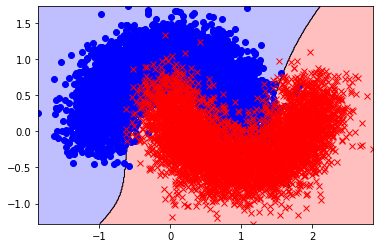

In [760]:
lamb = 10e-10
max_iter = 59
poly = PolynomialFeatures(degree = 7)
model = make_pipeline(poly, LogisticRegression(penalty = 'l2', C = 1 / lamb, max_iter = max_iter))
model.fit(X,y)    
#print(model)
print(f"Val accuracy: {model.score(X_val,y_val)*100}%")
print(f"Lamb: {lamb}")
print(f"Iter: {max_iter}")
plot_data(X_val,y_val)
plot_boundary(model, X_val) 

C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test accuracy: 93.66%
Lamb: 1e-09
Iter: 59


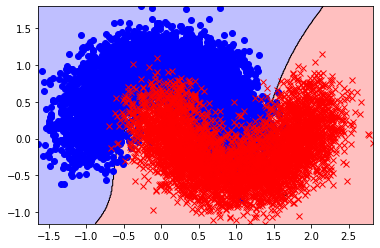

In [761]:
lamb = 10e-10
max_iter = 59
poly = PolynomialFeatures(degree = 7)
model = make_pipeline(poly, LogisticRegression(penalty = 'l2', C = 1 / lamb, max_iter = max_iter))
model.fit(X,y)    
#print(model)
print(f"Test accuracy: {model.score(X_test,y_test)*100}%")
print(f"Lamb: {lamb}")
print(f"Iter: {max_iter}")
plot_data(X_test,y_test)
plot_boundary(model, X_test) 

**Justifique a sua escolha. Em particular, você consegue justificar que o modelo não está sofrendo nem de underfitting nem de overfitting?** Sim. Após analisar a acurácia, tanto para teste quanto para validação, percebe-se que o modelo ajustou corretamente aos dados.

## Avaliação do modelo

Todos os itens abaixo se referem ao modelo escolhido no item anterior, o qual não deve ser mais alterado.

3. Para o modelo escolhido, meça a acurácia de teste. 
1. Calcule a matriz de confusão sobre o conjunto de validação.
1. Calcule a taxa de verdadeiro positivo e a taxa de falso positivo.
1. Trace o gráfico da curva ROC.
1. Determine a menor taxa de falso positivo tal que a taxa de falso negativo seja de no máximo 5%. Determine também o valor do limiar de decisão correspondente.
1. (OPCIONAL) Qual parâmetro deve ser modificado no modelo para que obtenha as taxas do item anterior?
1. (OPCIONAL) Compare a abordagem acima com a seguinte abordagem: treine novamente o modelo, variando os pesos do parâmetro `class_weight`, até conseguir a taxa de falso negativo desejada. Quais lhe parecem ser as vantagens e desvantagens dessa abordagem?

#### Dicas
- Funções úteis:
```python
from sklearn.metrics import confusion_matrix, roc_curve
np.where(), np.nonzero()
```

In [762]:
lamb = 10e-10
max_iter = 59
poly = PolynomialFeatures(degree = 7)
model = make_pipeline(poly, LogisticRegression(penalty = 'l2', C = 1 / lamb, max_iter = max_iter))
model.fit(X,y)

C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=7, include_bias=True,
                                    interaction_only=False, order='C')),
                ('logisticregression',
                 LogisticRegression(C=999999999.9999999, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=59, multi_class='auto',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [763]:
y_val_pred = model.predict(X_val)

In [764]:
y_test_pred = model.predict(X_test)

**Para o modelo escolhido, meça a acurácia de teste**

In [765]:
print(f"Test accuracy: {model.score(X_test,y_test)*100}%")

Test accuracy: 93.66%


**Calcule a matriz de confusão sobre o conjunto de validação**

In [766]:
from sklearn.metrics import confusion_matrix, roc_curve,plot_roc_curve, plot_confusion_matrix, roc_auc_score

In [767]:
confusion_matrix = confusion_matrix(y_val, y_val_pred)
confusion_matrix

array([[4750,  250],
       [ 348, 4652]], dtype=int64)

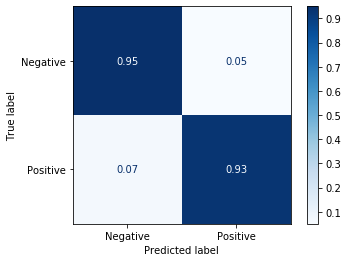

In [768]:
plt_confusion_matrix = plot_confusion_matrix(model, X_val,y_val, cmap=plt.cm.Blues,display_labels = ['Negative','Positive'], normalize = 'true')
plt_confusion_matrix

1. Calcule a taxa de verdadeiro positivo e a taxa de falso positivo.

In [769]:
TN = (4750 / (348+4750)) * 100
FN = (348 / (348+4750)) * 100
TP = (4652 / (250+4652)) * 100
FP = (250 / (250+4652)) * 100
print(f"True positive: {round(TP,2)}%")
print(f"False positive: {round(FP,2)}%")
print(f"True negative: {round(TN,2)}%")
print(f"False negative: {round(FN,2)}%")

True positive: 94.9%
False positive: 5.1%
True negative: 93.17%
False negative: 6.83%


Trace o gráfico da curva ROC.

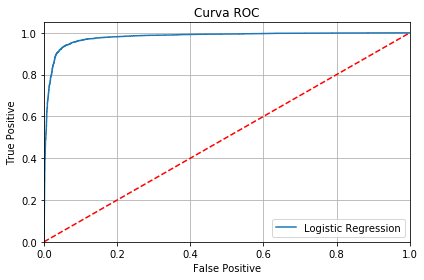

In [770]:
plot_roc_curve(model, X_val, y_val)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('Curva ROC')
plt.legend([f"Logistic Regression"])
plt.savefig('Log_ROC')
plt.grid()
plt.tight_layout()

Determine a menor taxa de falso positivo tal que a taxa de falso negativo seja de no máximo 5%. Determine também o valor do limiar de decisão correspondente.

In [771]:
tpr = (4652 / (4652 + 348))*100
fpr = (250 / (4652 + 250))*100
print(f"FPR: {round(fpr,2)}")
print(f"TPR: {tpr}")

FPR: 5.1
TPR: 93.04


In [772]:
fpr, tpr, th = roc_curve(y_val, y_val_pred)
print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"Threshold: {th}")

FPR: [0.   0.05 1.  ]
TPR: [0.     0.9304 1.    ]
Threshold: [2 1 0]


**=======================================================================================================================**

# 5. Conjunto de dados #5

O próximo [conjunto de dados](https://scikit-learn.org/stable/datasets/index.html#iris-dataset) é real: foi introduzido R. A. Fisher em 1936 e tornou-se um clássico da área, sendo muito utilizado até hoje por quem está iniciando. Consiste de 4 atributos medidos de 150 amostras de 3 espécies de flores do gênero íris.

O objetivo é distinguir entre as 3 espécies, i.e., trata-se de um problema de classificação multi-classe. O conjunto de dados é pequeno e o objetivo do exercício é apenas ilustrar a classificação multi-classe; assim, utilize todo o conjunto de dados como conjunto de treinamento.

O conjunto de dados pode ser carregado pelos comandos abaixo.

In [773]:
from sklearn.datasets import load_iris
data = load_iris()
print(data['feature_names'])
print(data['target_names'])
X = data['data']
y = data['target']
print(X.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 4) (150,)


## Classificação multi-classe: regressão logística one-vs-rest

1. Treine um classificador linear (i.e., com os atributos originais) por regressão logística sem regularização, e reporte a acurácia e a matriz de confusão. Inicialmente, utilize a opção `multi_class='ovr'` (one-vs-rest).
1. Escolha dois atributos e considere um conjunto de dados simplificado contendo apenas esses dois atributos (para permitir a visualização). Treine, calcule a acurácia e trace as regiões de decisão. Qual par de atributos permitiu a maior acurácia?

Acurácia: 95.33%


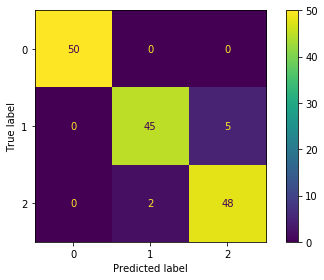

In [774]:
model = LogisticRegression(multi_class='ovr')
model.fit(X,y)

print(f"Acurácia: {round(model.score(X,y)*100,2)}%")
plot_confusion_matrix(model,X,y)
plt.tight_layout()

In [775]:
import pandas as pd
df = pd.DataFrame(data = X, columns = data['feature_names'])
df['label'] = y
df['species'] = pd.Categorical.from_codes(y,data['target_names'])
df.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa


In [776]:
df = df.to_numpy()

=========================================================================================================================

#### Sepal

Acurácia: 80.67%


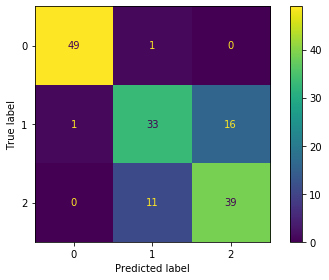

In [777]:
X = df[:,:2]
y = df[:,4].astype('int')

model = LogisticRegression(multi_class='ovr')
model.fit(X,y)

print(f"Acurácia: {round(model.score(X,y)*100,2)}%")
plot_confusion_matrix(model,X,y)
plt.tight_layout()

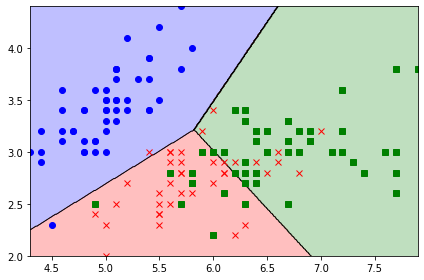

In [778]:
plot_data(X,y)
plot_boundary(model,X)
plt.tight_layout()

=========================================================================================================================

#### Petal

Acurácia: 96.67%


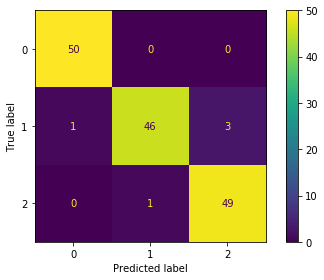

In [779]:
X = df[:,2:4]
y = df[:,4].astype('int')

model = LogisticRegression(multi_class='ovr')
model.fit(X,y)

print(f"Acurácia: {round(model.score(X,y)*100,2)}%")
plot_confusion_matrix(model,X,y)
plt.tight_layout()

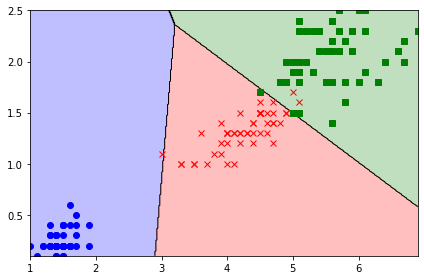

In [780]:
plot_data(X,y)
plot_boundary(model,X)
plt.tight_layout()

**Qual par de atributos permitiu a maior acurácia?** Petal obteve o maior valor de acurácia.

## Classificação multi-classe: regressão softmax

3. Agora, substitua pela opção `multi_class='multinomial'` e repita os itens da seção anterior. Você percebeu alguma diferença?

In [781]:
from sklearn.datasets import load_iris
data = load_iris()
print(data['feature_names'])
print(data['target_names'])
X = data['data']
y = data['target']
print(X.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 4) (150,)


C:\Users\victo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Acurácia: 97.33%


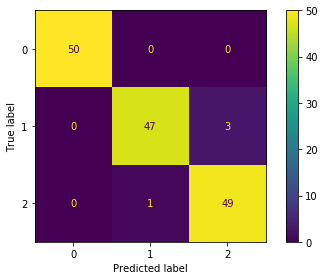

In [782]:
model = LogisticRegression(multi_class='multinomial')
model.fit(X,y)

print(f"Acurácia: {round(model.score(X,y)*100,2)}%")
plot_confusion_matrix(model,X,y)
plt.tight_layout()

In [783]:
import pandas as pd
df = pd.DataFrame(data = X, columns = data['feature_names'])
df['label'] = y
df['species'] = pd.Categorical.from_codes(y,data['target_names'])
df.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa


In [784]:
df = df.to_numpy()

=========================================================================================================================

#### Sepal

Acurácia: 82.0%


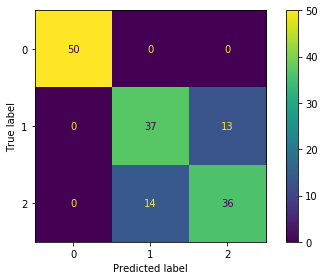

In [785]:
X = df[:,:2]
y = df[:,4].astype('int')

model = LogisticRegression(multi_class='multinomial')
model.fit(X,y)

print(f"Acurácia: {round(model.score(X,y)*100,2)}%")
plot_confusion_matrix(model,X,y)
plt.tight_layout()

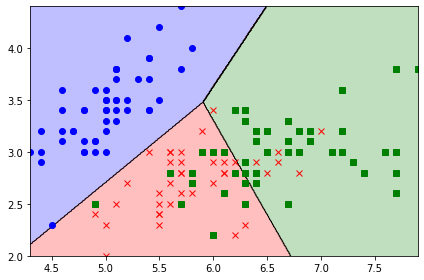

In [786]:
plot_data(X,y)
plot_boundary(model,X)
plt.tight_layout()

=========================================================================================================================

#### Petal

Acurácia: 96.67%


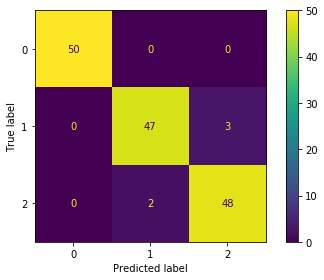

In [787]:
X = df[:,2:4]
y = df[:,4].astype('int')

model = LogisticRegression(multi_class='multinomial')
model.fit(X,y)

print(f"Acurácia: {round(model.score(X,y)*100,2)}%")
plot_confusion_matrix(model,X,y)
plt.tight_layout()

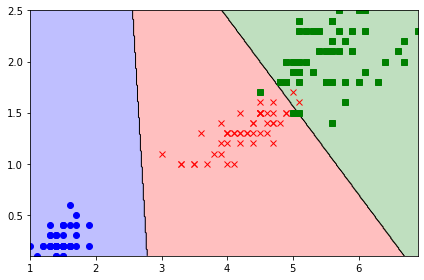

In [788]:
plot_data(X,y)
plot_boundary(model,X)
plt.tight_layout()

A acurácia de treinamento aumentou, pois teve um pequeno aumento na acurácia dos atributos sepal.

## (OPCIONAL) Implementação em Python

4. Escreva uma implementação própria da classificação *one-vs-rest* e confirme que o resultado é idêntico ao do sklearn. Note que isso envolve utilizar $K=3$ classificadores binários distintos, cada um treinado sobre um conjunto de dados com variável de saída $y_k$ correspondente ao $k$-ésimo elemento do vetor resultante da binarização (*one-hot encoding*) do rótulo da classe, i.e., $y \in \{0,1,\ldots,K-1\} \mapsto \by = (y_0,\ldots,y_{K-1})$. Nesse caso, escolhe-se como predição a classe que possui maior valor de discriminante, obtido pela função `decision_function`. Para facilitar, uma implementação parcial é fornecida abaixo.

#### Dicas
- Funções úteis:
```python
np.argmax()
from sklearn.preprocessing import label_binarize
```
- Uma implementação completa, incluindo a função `.fit()`, é fornecida em `sklearn.multiclass.OneVsRestClassifier`

In [789]:
from sklearn.base import BaseEstimator, ClassifierMixin

class OneVsRest(BaseEstimator, ClassifierMixin):
    ''' One-Vs-Rest Classification '''    
    def __init__(self, classifiers):
        self.classifiers = classifiers # list of *already fitted* binary classifiers
        return
       
    def predict(self, X):
        z = np.zeros((X.shape[0],len(self.classifiers)))
        for k in range(len(self.classifiers)):
            z[:,k] = ???
        y_pred = ???
        return y_pred

SyntaxError: invalid syntax (<ipython-input-789-27076a912a1d>, line 12)

In [ ]:
from sklearn.preprocessing import label_binarize
y_bi = ???
models = [[]]*3
for k in range(3):
    models[k] = ???
    ???

model = OneVsRest(models)
model.score(X, y)

# 6. (OPCIONAL) Conjunto de dados #6

Para investigar a diferença entre a classificação one-vs-rest e softmax, utilize o conjunto de dados abaixo.

In [ ]:
X, y = gen_data(n_samples=30, n_classes=4, overlap=0, random_state=1)
plot_data(X, y)

1. Compare a acurácia e as regiões de decisão para os dois tipos de classificação.
1. Para tentar investigar a razão das diferenças, trace a curva de predição da regressão para cada classe ($\tilde{y}_k$), para cada método.
 1. Para o método one-vs-rest, parta da função `.decision_function()`
 1. Para o método softmax, utilize a função `.predict_proba()`
1. A partir destes resultados, como você explicaria as diferenças entre os métodos? Em que tipo de situação você espera que as diferenças fiquem mais pronunciadas?